# Stable Diffusion Dreambooth (Finetuning)


[![stars - badge-generator](https://img.shields.io/github/stars/bacalhau-project/bacalhau?style=social)](https://github.com/bacalhau-project/bacalhau)

## Introduction

Stable diffusion has revolutionalized text2image models by producing high quality images based on a prompt. Dreambooth is a approach for personalization of text-to-image diffusion models. With images as input subject, we can fine-tune a pretrained text-to-image model

Although the [dreambooth paper](https://arxiv.org/abs/2208.12242) used [Imagen](https://imagen.research.google/) to finetune the pre-trained model since both the Imagen model and Dreambooth code are closed source, several opensource projects have emerged using stable diffusion.

Dreambooth makes stable-diffusion even more powered with the ability to generate realistic looking pictures of humans, animals or any other object by just training them on 20-30 images. 

In this example tutorial, we will be fine-tuning a pretrained stable diffusion using images of a human and generating images of him drinking coffee.

## TD;LR
The following command generates the following:
- **Subject**: SBF
- **Prompt**: a photo of SBF without hair

```
bacalhau docker run \
 --gpu 1 \
 --timeout 3600 \
 --wait-timeout-secs 3600 \
  -i QmRKnvqvpFzLjEoeeNNGHtc7H8fCn9TvNWHFnbBHkK8Mhy  \
  jsacex/dreambooth:full \
  -- bash finetune.sh /inputs /outputs "a photo of sbf man" "a photo of man" 3000 "/man" "/model"
```


### Inference
```
bacalhau docker run \
 --gpu 1 \
  -v QmUEJPr5pfV6tRzWQuNSSb3wdcN6tRQS5tdk3dYSCJ55Xs:/SBF.ckpt \
   jsacex/stable-diffusion-ckpt \
   -- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of sbf without hair" --plms --ckpt ../SBF.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs 
```
Output:


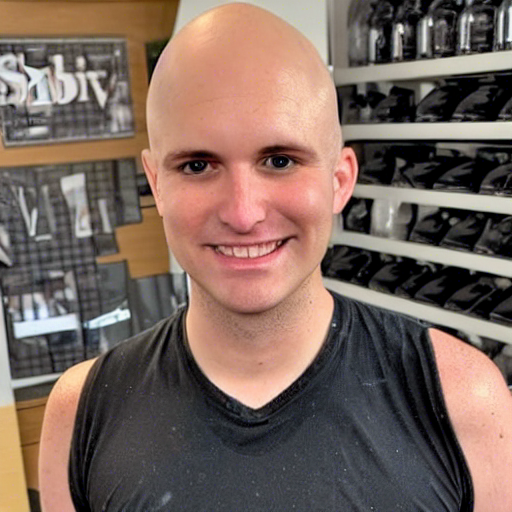


## Prerequisite

To get started, you need to install the Bacalhau client, see more information [here](https://docs.bacalhau.org/getting-started/installation)


## Setting up Docker Container

:::info
You can skip this section entirely and directly go to running a job on bacalhau
:::

Building this container requires you to have a supported GPU which needs to have 16gb+ of memory, since it can be resource intensive.

We will create a  `Dockerfile` and add the desired configuration to the file. These commands specify how the image will be built, and what extra requirements will be included.


```Dockerfile
FROM pytorch/pytorch:1.12.1-cuda11.3-cudnn8-devel
WORKDIR /
# Install requirements
# RUN git clone https://github.com/TheLastBen/diffusers
RUN apt update && apt install wget git unzip -y
RUN wget -q https://gist.githubusercontent.com/js-ts/28684a7e6217214ec944a9224584e9af/raw/d7492bc8f36700b75d51e3346259d1a466b99a40/train_dreambooth.py
RUN wget -q https://github.com/TheLastBen/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# RUN cp /content/convert_diffusers_to_original_stable_diffusion.py /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py
RUN pip install -qq git+https://github.com/TheLastBen/diffusers
RUN pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio natsort
# Install xformers
RUN pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl

RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Women' -O woman.zip

RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Men' -O man.zip

RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Mix' -O mix.zip

RUN unzip -j woman.zip -d woman

RUN unzip -j man.zip -d man

RUN unzip -j mix.zip -d mix
```

This container is using the `pytorch/pytorch:1.12.1-cuda11.3-cudnn8-devel` image and the working directory is set. Next, we add our custom code and pull the dependent repositories.

```finetune.sh
python clear_mem.py

accelerate launch train_dreambooth.py \
    --image_captions_filename \
   --train_text_encoder \
    --save_n_steps=$(expr $5 / 6) \
    --stop_text_encoder_training=$(expr $5 + 100) \
       --class_data_dir="$6" \
  --pretrained_model_name_or_path=${7:=/model} \
--tokenizer_name=${7:=/model}/tokenizer/ \
    --instance_data_dir="$1" \
    --output_dir="$2" \
    --instance_prompt="$3" \
   --class_prompt="$4" \
    --seed=96576 \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 \
    --use_8bit_adam \
    --learning_rate=2e-6 \
    --lr_scheduler="polynomial" \
    --center_crop \
    --lr_warmup_steps=0 \
    --max_train_steps=$5

echo  Convert weights to ckpt
python convert_diffusers_to_original_stable_diffusion.py --model_path $2  --checkpoint_path $2/model.ckpt --half
echo model saved at $2/model.ckpt
```

The shell script is there to make things much simpler, since the command to train the model needs many parameters to pass and later convert the model weights to checkpoint, you can edit this script and add in your own parameters

### Downloading the models

To download the models and run a test job in the Docker file, copy the following:

```Dockerfile
FROM pytorch/pytorch:1.12.1-cuda11.3-cudnn8-devel
WORKDIR /
# Install requirements
# RUN git clone https://github.com/TheLastBen/diffusers
RUN apt update && apt install wget git unzip -y
RUN wget -q https://gist.githubusercontent.com/js-ts/28684a7e6217214ec944a9224584e9af/raw/d7492bc8f36700b75d51e3346259d1a466b99a40/train_dreambooth.py
RUN wget -q https://github.com/TheLastBen/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# RUN cp /content/convert_diffusers_to_original_stable_diffusion.py /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py
RUN pip install -qq git+https://github.com/TheLastBen/diffusers
RUN pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio natsort
# Install xformers
RUN pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
RUN mkdir -p ~/.huggingface
RUN echo -n "<your-hugging-face-token>" > ~/.huggingface/token
# copy the test dataset from a local file
# COPY jfk /jfk

# Download and extract the test dataset
RUN wget https://github.com/js-ts/test-images/raw/main/jfk.zip
RUN unzip -j jfk.zip -d jfk
RUN mkdir model
RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Women' -O woman.zip
RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Men' -O man.zip
RUN wget 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/Dreambooth/Regularization/Mix' -O mix.zip
RUN unzip -j woman.zip -d woman
RUN unzip -j man.zip -d man
RUN unzip -j mix.zip -d mix

RUN  accelerate launch train_dreambooth.py \
    --image_captions_filename \
   --train_text_encoder \
    --save_starting_step=5\
    --stop_text_encoder_training=31 \
       --class_data_dir=/man \
    --save_n_steps=5 \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
    --instance_data_dir="/jfk" \
    --output_dir="/model" \
    --instance_prompt="a photo of jfk man" \
   --class_prompt="a photo of man" \
    --instance_prompt="" \
    --seed=96576 \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 \
    --use_8bit_adam \
    --learning_rate=2e-6 \
    --lr_scheduler="polynomial" \
    --center_crop \
    --lr_warmup_steps=0 \
    --max_train_steps=30

COPY finetune.sh /finetune.sh

RUN wget -q https://gist.githubusercontent.com/js-ts/624fecc3fff807d4948688cb28993a94/raw/fd69ac084debe26a815485c1f363b8a45566f1ba/clear_mem.py
# Removing your token
RUN rm -rf  ~/.huggingface/token
```

finetune.sh
```finetune.sh
python clear_mem.py

accelerate launch train_dreambooth.py \
    --image_captions_filename \
   --train_text_encoder \
    --save_n_steps=$(expr $5 / 6) \
    --stop_text_encoder_training=$(expr $5 + 100) \
       --class_data_dir="$6" \
  --pretrained_model_name_or_path=${7:=/model} \
--tokenizer_name=${7:=/model}/tokenizer/ \
    --instance_data_dir="$1" \
    --output_dir="$2" \
    --instance_prompt="$3" \
   --class_prompt="$4" \
    --seed=96576 \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 \
    --use_8bit_adam \
    --learning_rate=2e-6 \
    --lr_scheduler="polynomial" \
    --center_crop \
    --lr_warmup_steps=0 \
    --max_train_steps=$5

echo  Convert weights to ckpt
python convert_diffusers_to_original_stable_diffusion.py --model_path $2  --checkpoint_path $2/model.ckpt --half
echo model saved at $2/model.ckpt
```

### Build the Docker container 

We will run `docker build` command to build the container;

```
docker build -t <hub-user>/<repo-name>:<tag> .
```

Before running the command replace;

- **hub-user** with your docker hub username, If you don’t have a docker hub account [follow these instructions to create docker account](https://docs.docker.com/docker-id/), and use the username of the account you created

- **repo-name** with the name of the container, you can name it anything you want

- **tag** this is not required but you can use the latest tag


Now you can push this repository to the registry designated by its name or tag.

```
docker push <hub-user>/<repo-name>:<tag>
```

### Create the Subject Dataset

The optimal dataset size is between 20-30 images. You can choose the images of the subject in different positions, full body images, half body, pictures of the face etc.

Only the subject should appear in the image so you can crop the image to just fit the subject. Make sure that the images are of 512x512 size and are named in the following pattern since the subject name is David Aronchick we name the images in the following pattern

```
David Aronchick.jpg, David Aronchick (2).jpg ... David Aronchick (n).jpg
```

You can view the [Subject Image dataset of David Aronchick](https://bafybeidqbuphwkqwgrobv2vakwsh3l6b4q2mx7xspgh4l7lhulhc3dfa7a.ipfs.nftstorage.link) for refernce

After the Subject dataset is created we upload it to IPFS

## Uploading the Subject Images to IPFS

In this case we will be using [NFT.Storage](https://nft.storage/) (Recommneded Option) to upload files and directories with [NFTUp](https://nft.storage/docs/how-to/nftup/) 

To upload your dataset using NFTup just drag and drop your directory it will upload it to IPFS

![](https://i.imgur.com/g3VM2Kp.png)

After the checkpoint file has been uploaded copy its CID `bafybeidqbuphwkqwgrobv2vakwsh3l6b4q2mx7xspgh4l7lhulhc3dfa7a`

## Approaches to run a Bacalhau Job on a Finetuned Model

Since there are a lot of combinations that you can try, processing of finetuned model can take almost 1hr+ to complete. Here are some few approaches that you can try based upon your requirements


### Case0 If the subject is of class male
```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-i <CID-OF-THE-SUBJECT> \
 jsacex/dreambooth:full \
-- bash finetune.sh /inputs /outputs "a photo of <name-of-the-subject> man" "a photo of man" 3000 "/man" "/model"
```


Structure of the command 

- No of GPUs --gpu 1

- CID of the Subject Images -i bafybeidqbuphwkqwgrobv2vakwsh3l6b4q2mx7xspgh4l7lhulhc3dfa7a

- Name of our Image jsacex/dreambooth:latest

-- bash finetune.sh /inputs /outputs "a photo of aronchick man" "a photo of man" 3000 "/man"

- Path to the subject Images /inputs

- Path to save the generated outputs /outputs

- Subject name along with class   "a photo of < name of the subject > < class >" -> "a photo of aronchick man" 

- Name of the class   "a photo of < class >" -> "a photo of man" 

Number of iterations is 3000 this number should be no of subject images x 100. So if there are 30 Images it would be 3000, it takes around 32Mins on a v100 for 3000 Iterations but you can increase/decrease the number based on your requirements

Path to our class Images /man

Here is our command with our parameters replaced


In [ ]:
%%bash --out job_id
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-i bafybeidqbuphwkqwgrobv2vakwsh3l6b4q2mx7xspgh4l7lhulhc3dfa7a \
--wait \
--id-only \
  jsacex/dreambooth:full \
-- bash finetune.sh /inputs /outputs "a photo of aronchick man" "a photo of man" 3000 "/man" "/model"

If your subject fits the above class but has a different name you just need to replace the input CID and the subject name which in this case is SBF
```
 bacalhau docker run \
 --gpu 1 \
-i QmRKnvqvpFzLjEoeeNNGHtc7H8fCn9TvNWHFnbBHkK8Mhy \
  jsacex/dreambooth:full \
-- bash finetune.sh /inputs /outputs "a photo of sbf man" "a photo of man" 3000 "/man"  "/model"
```

### Case1 If the subject is of class female

Use the `/woman` class images

```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-i <CID-OF-THE-SUBJECT> \
  jsacex/dreambooth:full \
-- bash finetune.sh /inputs /outputs "a photo of <name-of-the-subject> woman" "a photo of woman" 3000 "/woman"  "/model"
```

### Case2 If the subject is of class mix 
provide your own regularization images or use the mix class

Use the `/mix` class images if the class of the subject is mix

```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-i <CID-OF-THE-SUBJECT> \
  jsacex/dreambooth:full \
-- bash finetune.sh /inputs /outputs "a photo of <name-of-the-subject> mix" "a photo of mix" 3000 "/mix"  "/model"
```

### Case3 If you want to a different tokenizer, model and a different shell script with custom parameters

You can upload the model to IPFS and then create a gist and mount the model and script to the lightweight container

```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-v bafybeidqbuphwkqwgrobv2vakwsh3l6b4q2mx7xspgh4l7lhulhc3dfa7a:/aronchick \
-v <CID-OF-THE-MODEL>:/model 
-u https://gist.githubusercontent.com/js-ts/54b270a36aa3c35fdc270640680b3bd4/raw/7d8e8fa47bc3811ef63772f7fc7f4360aa9d51a8/finetune.sh
--wait \
--id-only \
  jsacex/dreambooth:lite \
-- bash /inputs/finetune.sh /aronchick /outputs "a photo of aronchick man" "a photo of man" 3000 "/man" "/model"
```

When a job is sumbitted, Bacalhau prints out the related `job_id`. We store that in an environment variable so that we can reuse it later on.

In [ ]:
%%env JOB_ID={job_id}

### Checking the State of your Jobs

- **Job status**: You can check the status of the job using `bacalhau list`. 

In [ ]:
%%bash
bacalhau list --id-filter ${JOB_ID} --wide

 CREATED            ID                                    JOB                                                                                                                  STATE      VERIFIED  PUBLISHED                                            
 22-11-14-07:16:17  9fcd210b-bc8a-4f38-bf5e-5ac39e0b8be4  Docker jsacex/dreambooth:latest bash finetune.sh /inputs /outputs a photo of aronchick man a photo of man 3000 /man  Completed            /ipfs/QmcmD7M7pYLP8QgwjqpbP4dojRLiLuEBdhevuCD9kFmbdV 


When it says `Published` or `Completed`, that means the job is done, and we can get the results.

- **Job information**: You can find out more information about your job by using `bacalhau describe`.

In [ ]:
%%bash
bacalhau describe ${JOB_ID}

In the next steps, we will be doing inference on the finetuned model

## Inference on the Fine Tuned Model

:::info

Refer https://docs.bacalhau.org/examples/model-inference/Stable-Diffusion-CKPT-Inference on details of how to build a SD inference container
:::

Bacalhau currently doesn't support mounting subpaths of the CID, so instead of just mounting the _model.ckpt_ file we need to mount the whole output CID which is of 6.4GB, which might results in errors like FAILED TO COPY /inputs. So you have to manually copy the CID of the _model.ckpt_ which is of 2GB

To get the CID of the _model.ckpt_ file go to https://gateway.ipfs.io/ipfs/< YOUR-OUTPUT-CID >/outputs/

https://gateway.ipfs.io/ipfs/QmcmD7M7pYLP8QgwjqpbP4dojRLiLuEBdhevuCD9kFmbdV/outputs/

If you use the Brave browser

```
ipfs://QmdpsqZn9BZx9XxzCsyPcJyS7yfYacmQXZxHzcuYwzmtGg/outputs
```
Using IPFS CLI

```
ipfs ls QmdpsqZn9BZx9XxzCsyPcJyS7yfYacmQXZxHzcuYwzmtGg/outputs
```

![image](https://imgur.com/S2WSZTA.png)

Copy the link of _model.ckpt_ highlighted in the box https://gateway.ipfs.io/ipfs/QmdpsqZn9BZx9XxzCsyPcJyS7yfYacmQXZxHzcuYwzmtGg?filename=model.ckpt

Extract the CID portion of the link and copy it

### Run the Bacalhau Job on the Fine-Tuned Model

To run a Bacalhau Job on the fine-tuned model, we will use the `bacalhau docker run` command. 

In [ ]:
%%bash --out job_id
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--wait \
--id-only \
-i QmdpsqZn9BZx9XxzCsyPcJyS7yfYacmQXZxHzcuYwzmtGg \
jsacex/stable-diffusion-ckpt \
-- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of aronchick drinking coffee" --plms --ckpt ../inputs/model.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs 

If you are facing difficulties using the above method you can mount the whole output CID

```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--wait \
--id-only \
-i QmcmD7M7pYLP8QgwjqpbP4dojRLiLuEBdhevuCD9kFmbdV \
jsacex/stable-diffusion-ckpt \
-- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of aronchick drinking coffee" --plms --ckpt ../inputs/outputs/model.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs 
```

When a job is sumbitted, Bacalhau prints out the related `job_id`. We store that in an environment variable so that we can reuse it later on.

In [ ]:
%%env JOB_ID={job_id}

### Checking the State of your Jobs
- **Job status**: You can check the status of the job using `bacalhau list`. 

In [ ]:
%%bash
bacalhau list --id-filter ${JOB_ID} --wide

 CREATED            ID                                    JOB                                                                                                                                                                                                                                                    STATE      VERIFIED  PUBLISHED                                            
 22-11-14-08:44:56  3c5e4faa-ab2e-4576-bd61-e31140493196  Docker jsacex/stable-diffusion-ckpt conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt a photo of aronchick drinking coffee --plms --ckpt ../inputs/outputs/model.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs  Completed            /ipfs/Qmep1mvj6RkyWa5Hptz6JhpAXAZziPDtStEopJjBYav6MM 


When it says `Published` or `Completed`, that means the job is done, and we can get the results.

- **Job information**: You can find out more information about your job by using `bacalhau describe`.

In [ ]:
%%bash
bacalhau describe ${JOB_ID}

- **Job download**: You can download your job results directly by using `bacalhau get`. Alternatively, you can choose to create a directory to store your results. In the command below, we created a directory and downloaded our job output to be stored in that directory.

In [ ]:
%%bash
rm -rf results && mkdir -p results
bacalhau get $JOB_ID --output-dir results

Fetching results of job '3c5e4faa-ab2e-4576-bd61-e31140493196'...
Results for job '3c5e4faa-ab2e-4576-bd61-e31140493196' have been written to...
results


2022/11/14 09:29:52 failed to sufficiently increase receive buffer size (was: 208 kiB, wanted: 2048 kiB, got: 416 kiB). See https://github.com/lucas-clemente/quic-go/wiki/UDP-Receive-Buffer-Size for details.


After the download has finished you should see the following contents in results directory

## Viewing your Job Output

Each job creates 3 subfolders: the **combined_results**,**per_shard files**, and the **raw** directory. To view the file, run the following command:

%%bash
ls results/combined_results/outputs

### Display Image

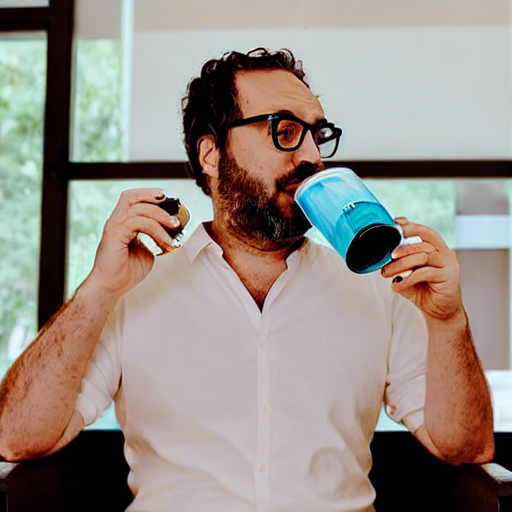

In [ ]:
import IPython.display as display
display.Image("results/combined_results/outputs/samples/00001.png")